## Multimodal Garbage Classification

Note: In order to see the results run the first code cell, where the libraries are imported, and then run the cell in the results section.

## Introduction

This notebook demonstrates the implementation of a multimodal classification model that combines image and text features using a ResNet feature extractor for images and a DistilBERT feature extractor for text. The model predicts one of four possible classes for each image-text pair.

## The necessary libraries are imported

texttable is imported in order to display a confusion matrix in ASCII (since TALC can can only save output in text files)

In [7]:
!pip install texttable
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import DistilBertModel, DistilBertTokenizer
from torchvision import models, transforms
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import texttable as tt



## Data loading and preprocessing

In [ ]:
def read_text_files_with_labels(path):
    texts = []
    labels = []
    image_paths=[]
    class_folders = sorted(os.listdir(path))
    label_map = {class_name: idx for idx, class_name in enumerate(class_folders)}

    for class_name in class_folders:
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            file_names = os.listdir(class_path)
            for file_name in file_names:
                file_path = os.path.join(class_path, file_name)

                if os.path.isfile(file_path):
                    image_paths.append(file_path) #adding this to the code to get a list of image paths
                    file_name_no_ext, _ = os.path.splitext(file_name)
                    text = file_name_no_ext.replace('_', ' ')
                    text_without_digits = re.sub(r'\d+', '', text)
                    texts.append(text_without_digits)
                    labels.append(label_map[class_name])

    return np.array(texts), np.array(labels), np.array(image_paths)


TRAIN_PATH = r"/work/TALC/enel645_2024f/garbage_data/CVPR_2024_dataset_Train"
VAL_PATH = r"/work/TALC/enel645_2024f/garbage_data/CVPR_2024_dataset_Val"
TEST_PATH = r"/work/TALC/enel645_2024f/garbage_data/CVPR_2024_dataset_Test"



a, b, c = read_text_files_with_labels(TRAIN_PATH)
a2, b2, c2 = read_text_files_with_labels(VAL_PATH)
a3, b3, c3 = read_text_files_with_labels(TEST_PATH)
temp_dictionary = {'text': a, 'label': b, 'image_path': c}
dataframe_train = pd.DataFrame(temp_dictionary)
dataframe_val = pd.DataFrame({'text': a2, 'label': b2, 'image_path': c2})
dataframe_test = pd.DataFrame({'text': a3, 'label': b3, 'image_path': c3})


## Create classes for the DistilBERT and ResNet models

In [ ]:

# Define ResNet and BERT models
class ResNetFeatureExtractor(nn.Module):
    def __init__(self):
        super(ResNetFeatureExtractor, self).__init__()
        resnet = models.resnet18(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])

    def forward(self, x):
        with torch.no_grad():
            features = self.feature_extractor(x)
        return features.view(features.size(0), -1)

class DistilBERTFeatureExtractor(nn.Module):
    def __init__(self):
        super(DistilBERTFeatureExtractor, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state[:, 0, :]

## Create class for the multimodal model

In [ ]:

# Define the multimodal classification model
class MultimodalClassifier(nn.Module):
    def __init__(self, num_classes):
        super(MultimodalClassifier, self).__init__()
        self.image_extractor = ResNetFeatureExtractor()
        self.text_extractor = DistilBERTFeatureExtractor()
        self.fc_image = nn.Linear(512, 256)
        self.fc_text = nn.Linear(768, 256)
        self.classifier = nn.Linear(512, num_classes)  # Concatenate image and text features

    def forward(self, input_ids, attention_mask, image):
        # Extract features
        image_features = self.image_extractor(image)
        text_features = self.text_extractor(input_ids, attention_mask)

        # Fully connected layers
        image_features = torch.relu(self.fc_image(image_features))
        text_features = torch.relu(self.fc_text(text_features))

        # Concatenate image and text features
        combined_features = torch.cat((image_features, text_features), dim=1)

        # Classification
        logits = self.classifier(combined_features)
        return logits

## Create a class for the multimodal data set

In [ ]:
# Define dataset class
class MultimodalDataset(Dataset):
    def __init__(self, dataframe, tokenizer, image_transform):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.image_transform = image_transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get text and image path
        text = self.dataframe.iloc[idx]['text']
        image_path = self.dataframe.iloc[idx]['image_path']
        label = self.dataframe.iloc[idx]['label']

        # Tokenize text
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors='pt'
        )

        # Load and transform image
        image = Image.open(image_path).convert('RGB')
        image = self.image_transform(image)

        # Extract input IDs and attention mask from encoding
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'image': image,
            'label': torch.tensor(label, dtype=torch.long)
        }


## Preprocessing, training, validation, and test setup

In [ ]:
# Training setup
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


train_dataset = MultimodalDataset(dataframe_train, tokenizer, image_transform)
val_dataset = MultimodalDataset(dataframe_val, tokenizer, image_transform)
test_dataset = MultimodalDataset(dataframe_test, tokenizer, image_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

# Model, criterion, optimizer, and device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 4
model = MultimodalClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Training and validation

In [ ]:
# Training and validation loop
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, image=images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Print epoch loss
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {avg_loss:.4f}")

    # Validation step
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, image=images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

print("Training complete.")

## Test loop

In [ ]:
def test_model(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, image=images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

## Confusion matrix and evaluation on test set

In [ ]:
 # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Create an ASCII representation of the confusion matrix using texttable
    tab = tt.Texttable()
    tab.add_row([""] + [f"Pred {i}" for i in range(len(cm))])
    for i, row in enumerate(cm):
        tab.add_row([f"True {i}"] + list(row))
    print(tab.draw())

    # Evaluate the model on the test set
test_model(model, test_loader, device)

## Results

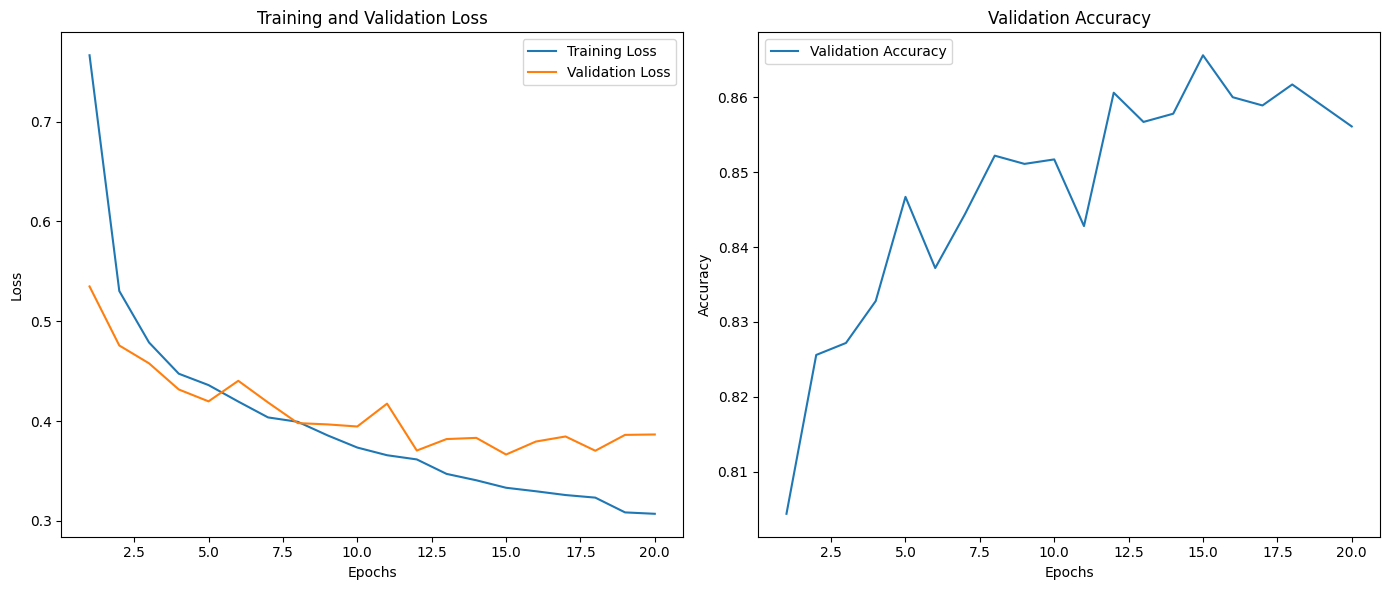

In [8]:

epochs = range(1, 21)
training_loss = [0.7666, 0.5303, 0.4787, 0.4474, 0.4360, 0.4195, 0.4036, 0.3992, 0.3856, 0.3734, 0.3657, 0.3615, 0.3470, 0.3406, 0.3331, 0.3296, 0.3258, 0.3232, 0.3084, 0.3070]
validation_loss = [0.5349, 0.4757, 0.4578, 0.4316, 0.4197, 0.4403, 0.4186, 0.3979, 0.3966, 0.3945, 0.4174, 0.3704, 0.3819, 0.3831, 0.3664, 0.3794, 0.3845, 0.3702, 0.3861, 0.3865]
validation_accuracy = [0.8044, 0.8256, 0.8272, 0.8328, 0.8467, 0.8372, 0.8444, 0.8522, 0.8511, 0.8517, 0.8428, 0.8606, 0.8567, 0.8578, 0.8656, 0.8600, 0.8589, 0.8617, 0.8589, 0.8561]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Display confusion matrix and accuracy

Confusion matrix is obtained from the slurm file output. The four numbes (0,1,2,3) correspond to the four clases (black, blue green, TTR respectively). Accuracy is also obtained from the slurm output file.

 Test Accuracy: 0.8001

In [ ]:
+--------+--------+--------+--------+--------+
|        | Pred 0 | Pred 1 | Pred 2 | Pred 3 |
+--------+--------+--------+--------+--------+
| True 0 | 517    | 72     | 43     | 63     |
+--------+--------+--------+--------+--------+
| True 1 | 129    | 875    | 60     | 21     |
+--------+--------+--------+--------+--------+
| True 2 | 29     | 19     | 746    | 5      |
+--------+--------+--------+--------+--------+
| True 3 | 117    | 93     | 35     | 607    |
+--------+--------+--------+--------+--------+